**File Set-Up**

In [ ]:
# The data is coming from our shared drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import joblib
import re
import pickle

import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Mounted at /content/drive


**Load and Prepare Data**

In [ ]:
# Load the dataset
!ls "/content/drive/Shared drives/CSI 5130/SemEval2018-Task1-all-data/English/E-c/train.txt"


# Define emotions
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
            'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Load Data
try:
    df = pd.read_csv(
        '/content/drive/Shared drives/CSI 5130/SemEval2018-Task1-all-data/English/E-c/train.txt',
        sep='\t',
        header=0,
        dtype={'ID': str, 'Tweet': str, **{e: int for e in emotions}}
    )
except Exception as e:
    raise

# Initial Emotion Counts
print("\nInitial label counts:")
print(df[emotions].sum())

'/content/drive/Shared drives/CSI 5130/SemEval2018-Task1-all-data/English/E-c/train.txt'

Initial label counts:
anger           2544
anticipation     978
disgust         2602
fear            1242
joy             2477
love             700
optimism        1984
pessimism        795
sadness         2008
surprise         361
trust            357
dtype: int64


**Clean and Preprocess Data**

In [ ]:
# Clean the tweets and preprocess the data

def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

df['clean_tweet'] = df['Tweet'].apply(clean_tweet)

trust_upsample = df[df['trust'] == 1]
surprise_upsample = df[df['surprise'] == 1]

# Oversampling the rare emotions
df = pd.concat([
    df,
    trust_upsample,
    trust_upsample,
    trust_upsample,
    trust_upsample,
    trust_upsample,
    surprise_upsample,
    surprise_upsample,
    surprise_upsample,
    surprise_upsample,
    surprise_upsample
], ignore_index=True)


df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify labels
print("\nLabel verification before splitting:")
print("Data types:", df[emotions].dtypes)
print("Label counts:")
print(df[emotions].sum())

# Handle any non-numeric values
for emotion in emotions:
    if df[emotion].dtype == object:
        print(f"\nConverting {emotion} column...")
        df[emotion] = pd.to_numeric(df[emotion], errors='coerce').fillna(0).astype(int)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(
    df['clean_tweet'],
    df[emotions],
    test_size=0.2,
    random_state=42
)


# Convert to numpy arrays
Y_train_values = Y_train.astype('float32').values
Y_test_values = Y_test.astype('float32').values


Label verification before splitting:
Data types: anger           int64
anticipation    int64
disgust         int64
fear            int64
joy             int64
love            int64
optimism        int64
pessimism       int64
sadness         int64
surprise        int64
trust           int64
dtype: object
Label counts:
anger           3119
anticipation    2138
disgust         3172
fear            1672
joy             4517
love            1250
optimism        3839
pessimism        945
sadness         2493
surprise        2271
trust           2247
dtype: int64


**Verify Data**

In [ ]:
# Clean the tweets using preprocessing functions
print("Label balance in full dataset:")
print(df[emotions].sum())

print("\nSample of labels and text:")
print(df[['clean_tweet'] + emotions].head(3))

Label balance in full dataset:
anger           3119
anticipation    2138
disgust         3172
fear            1672
joy             4517
love            1250
optimism        3839
pessimism        945
sadness         2493
surprise        2271
trust           2247
dtype: int64

Sample of labels and text:
                                         clean_tweet  anger  anticipation  \
0  wine drunk is the worst version of myself ffs ...      0             0   
1       it hasn t sunk in that i m meeting the twins      0             1   
2  woah that overtime was exhilarating out of my ...      0             1   

   disgust  fear  joy  love  optimism  pessimism  sadness  surprise  trust  
0        0     0    0     0         0          0        0         1      0  
1        0     0    0     0         1          0        0         0      0  
2        0     0    1     0         1          0        0         1      0  


**Tokenize and Pad Sequences**

In [ ]:
# Tokenize & Pad the Tweets

# Set tokenizer
vocab_size = 10000
max_length = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

**Build CNN Model**

In [ ]:
# CNN model
max_len = X_train_pad.shape[1]
num_classes = Y_train_values.shape[1]

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Dropout(0.3),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')
])

optimizer = Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc_1')]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Add Class Weighting**

In [ ]:
# Calculate weights per emotion
class_weights = {}
for i, emotion in enumerate(emotions):
    weights = compute_class_weight(
        'balanced',
        classes=np.unique(Y_train_values[:, i]),
        y=Y_train_values[:, i]
    )
    class_weights[i] = weights[1] if len(weights) > 1 else 1.0

print("Class weights:", class_weights)

Class weights: {0: np.float64(1.6584493041749504), 1: np.float64(2.4449003516998826), 2: np.float64(1.6499208860759493), 3: np.float64(3.1791158536585367), 4: np.float64(1.1424267324020816), 5: np.float64(4.117472852912142), 6: np.float64(1.364409551848217), 7: np.float64(5.5836680053547525), 8: np.float64(2.1002014098690838), 9: np.float64(2.3044198895027623), 10: np.float64(2.332774049217002)}


**Train Model**

In [ ]:
# Train the CNN model
history = model.fit(
    X_train_pad,
    Y_train_values,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_auc_1', mode='max', restore_best_weights=True),
        ModelCheckpoint('best_model.h5', monitor='val_auc_1', save_best_only=True, mode='max')
    ],
    verbose=1
)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1599 - auc_1: 0.5568 - loss: 1.1682

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.1601 - auc_1: 0.5568 - loss: 1.1671 - val_accuracy: 0.3018 - val_auc_1: 0.6751 - val_loss: 0.5402
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1739 - auc_1: 0.5923 - loss: 1.0394

59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.1740 - auc_1: 0.5925 - loss: 1.0393 - val_accuracy: 0.2515 - val_auc_1: 0.7139 - val_loss: 0.5292
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1917 - auc_1: 0.6656 - loss: 0.9755

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.1918 - auc_1: 0.6661 - loss: 0.9753 - val_accuracy: 0.2431 - val_auc_1: 0.8014 - val_loss: 0.4672
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2521 - auc_1: 0.7962 - loss: 0.8268

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2522 - auc_1: 0.7965 - loss: 0.8267 - val_accuracy: 0.3138 - val_auc_1: 0.8558 - val_loss: 0.3969
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3103 - auc_1: 0.8627 - loss: 0.7036

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.3105 - auc_1: 0.8628 - loss: 0.7035 - val_accuracy: 0.4012 - val_auc_1: 0.8845 - val_loss: 0.3531
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3700 - auc_1: 0.8996 - loss: 0.6191

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.3700 - auc_1: 0.8996 - loss: 0.6189 - val_accuracy: 0.3629 - val_auc_1: 0.8959 - val_loss: 0.3320
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3842 - auc_1: 0.9212 - loss: 0.5497

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.3843 - auc_1: 0.9212 - loss: 0.5496 - val_accuracy: 0.4359 - val_auc_1: 0.9041 - val_loss: 0.3167
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4217 - auc_1: 0.9336 - loss: 0.5086

59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.4217 - auc_1: 0.9336 - loss: 0.5085 - val_accuracy: 0.4156 - val_auc_1: 0.9130 - val_loss: 0.3029
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4481 - auc_1: 0.9437 - loss: 0.4644

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.4481 - auc_1: 0.9437 - loss: 0.4645 - val_accuracy: 0.4539 - val_auc_1: 0.9175 - val_loss: 0.2933
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4729 - auc_1: 0.9530 - loss: 0.4266

59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.4729 - auc_1: 0.9530 - loss: 0.4266 - val_accuracy: 0.4623 - val_auc_1: 0.9206 - val_loss: 0.2892
Epoch 11/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4785 - auc_1: 0.9597 - loss: 0.3986

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.4786 - auc_1: 0.9597 - loss: 0.3986 - val_accuracy: 0.4563 - val_auc_1: 0.9219 - val_loss: 0.2874
Epoch 12/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5023 - auc_1: 0.9646 - loss: 0.3717

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.5022 - auc_1: 0.9646 - loss: 0.3718 - val_accuracy: 0.4527 - val_auc_1: 0.9250 - val_loss: 0.2833
Epoch 13/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.4941 - auc_1: 0.9674 - loss: 0.3571 - val_accuracy: 0.4659 - val_auc_1: 0.9244 - val_loss: 0.2882
Epoch 14/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.5186 - auc_1: 0.9709 - loss: 0.3398 - val_accuracy: 0.4527 - val_auc_1: 0.9238 - val_loss: 0.2913
Epoch 15/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5022 - auc_1: 0.9740 - loss: 0.3227

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5021 - auc_1: 0.9740 - loss: 0.3227 - val_accuracy: 0.4431 - val_auc_1: 0.9250 - val_loss: 0.2906
Epoch 16/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.5027 - auc_1: 0.9755 - loss: 0.3093 - val_accuracy: 0.4551 - val_auc_1: 0.9230 - val_loss: 0.3009
Epoch 17/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5109 - auc_1: 0.9778 - loss: 0.2951 - val_accuracy: 0.4527 - val_auc_1: 0.9238 - val_loss: 0.2993
Epoch 18/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5031 - auc_1: 0.9789 - loss: 0.2906

59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.5032 - auc_1: 0.9789 - loss: 0.2906 - val_accuracy: 0.4275 - val_auc_1: 0.9254 - val_loss: 0.2983
Epoch 19/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.4976 - auc_1: 0.9805 - loss: 0.2801 - val_accuracy: 0.4551 - val_auc_1: 0.9249 - val_loss: 0.3043
Epoch 20/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.5170 - auc_1: 0.9812 - loss: 0.2734 - val_accuracy: 0.4491 - val_auc_1: 0.9254 - val_loss: 0.3025
Epoch 21/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5101 - auc_1: 0.9820 - loss: 0.2675 - val_accuracy: 0.4479 - val_auc_1: 0.9228 - val_loss: 0.3141
Epoch 22/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.5227 - auc_1: 0.9830 - loss: 0.2601 - val_accuracy: 0.4575 - val_auc_1: 0.9217 - val_loss: 0.3188
Epoch 23/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.5242 - auc_1: 0.9839 - loss: 0.2518 - val_accuracy: 0.4563 - val_auc_1: 0.9222 - val_loss: 0.3199


**Save Tokenizer**

In [ ]:
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


from google.colab import files
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Save Model**

In [ ]:
# Save CNN model
model.save("english_model.keras", include_optimizer=False)
!zip -r english_model.zip english_model.keras

# Download CNN model
from google.colab import files
files.download("english_model.zip")

  adding: english_model.keras (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Evaluate Performace**

In [ ]:
# Get predictions
pred_probs = model.predict(X_test_pad)
pred_labels = (pred_probs >= 0.3).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(Y_test_values, pred_labels, target_names=emotions, zero_division=0))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.69      0.84      0.76       604
anticipation       0.71      0.72      0.71       432
     disgust       0.68      0.81      0.74       644
        fear       0.77      0.78      0.77       360
         joy       0.85      0.86      0.85       866
        love       0.72      0.70      0.71       237
    optimism       0.73      0.84      0.78       782
   pessimism       0.37      0.43      0.40       198
     sadness       0.60      0.71      0.65       507
    surprise       0.89      1.00      0.94       461
       trust       0.81      0.96      0.88       459

   micro avg       0.73      0.82      0.77      5550
   macro avg       0.71      0.79      0.75      5550
weighted avg       0.73      0.82      0.77      5550
 samples avg       0.72      0.79      0.73      5550


Confusion Matrices:

anger:
[[ 510   94]
 [ 226 1256]]

anticipation:

**Bar Graph**

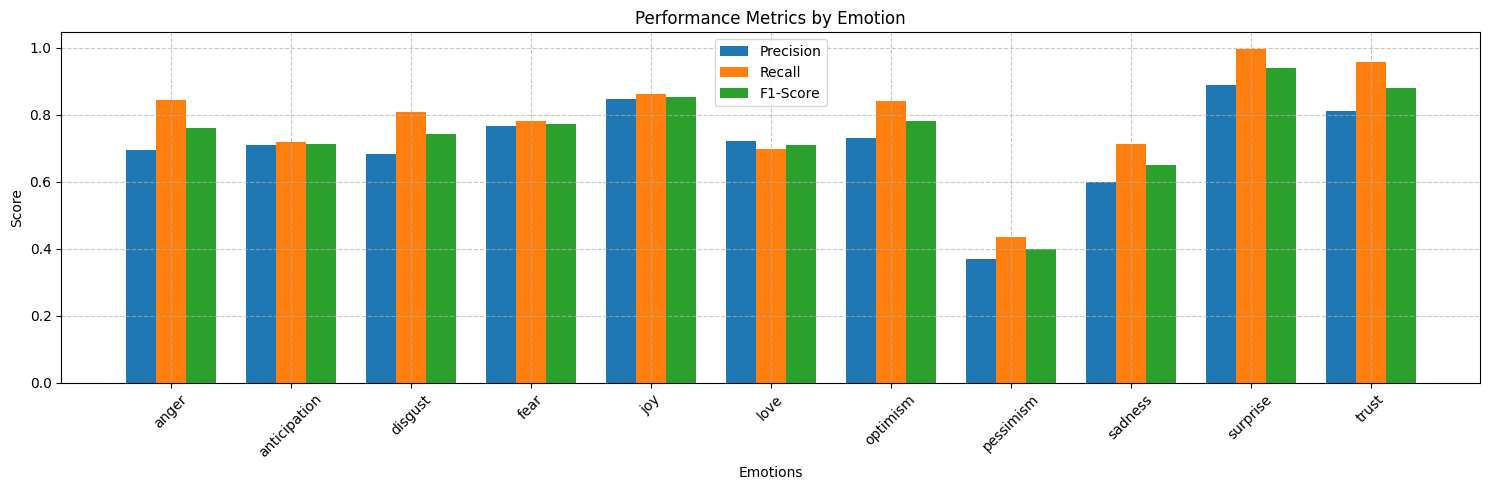

In [ ]:
#Metrics for each emotion
metrics = {
    'Precision': precision_score(Y_test_values, pred_labels, average=None),
    'Recall': recall_score(Y_test_values, pred_labels, average=None),
    'F1-Score': f1_score(Y_test_values, pred_labels, average=None)
}

# Plot graph
plt.figure(figsize=(15, 5))
x = np.arange(len(emotions))
width = 0.25

for i, (metric_name, values) in enumerate(metrics.items()):
    plt.bar(x + i*width, values, width, label=metric_name)

plt.xlabel('Emotions')
plt.ylabel('Score')
plt.title('Performance Metrics by Emotion')
plt.xticks(x + width, emotions, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Confusion Matrices**

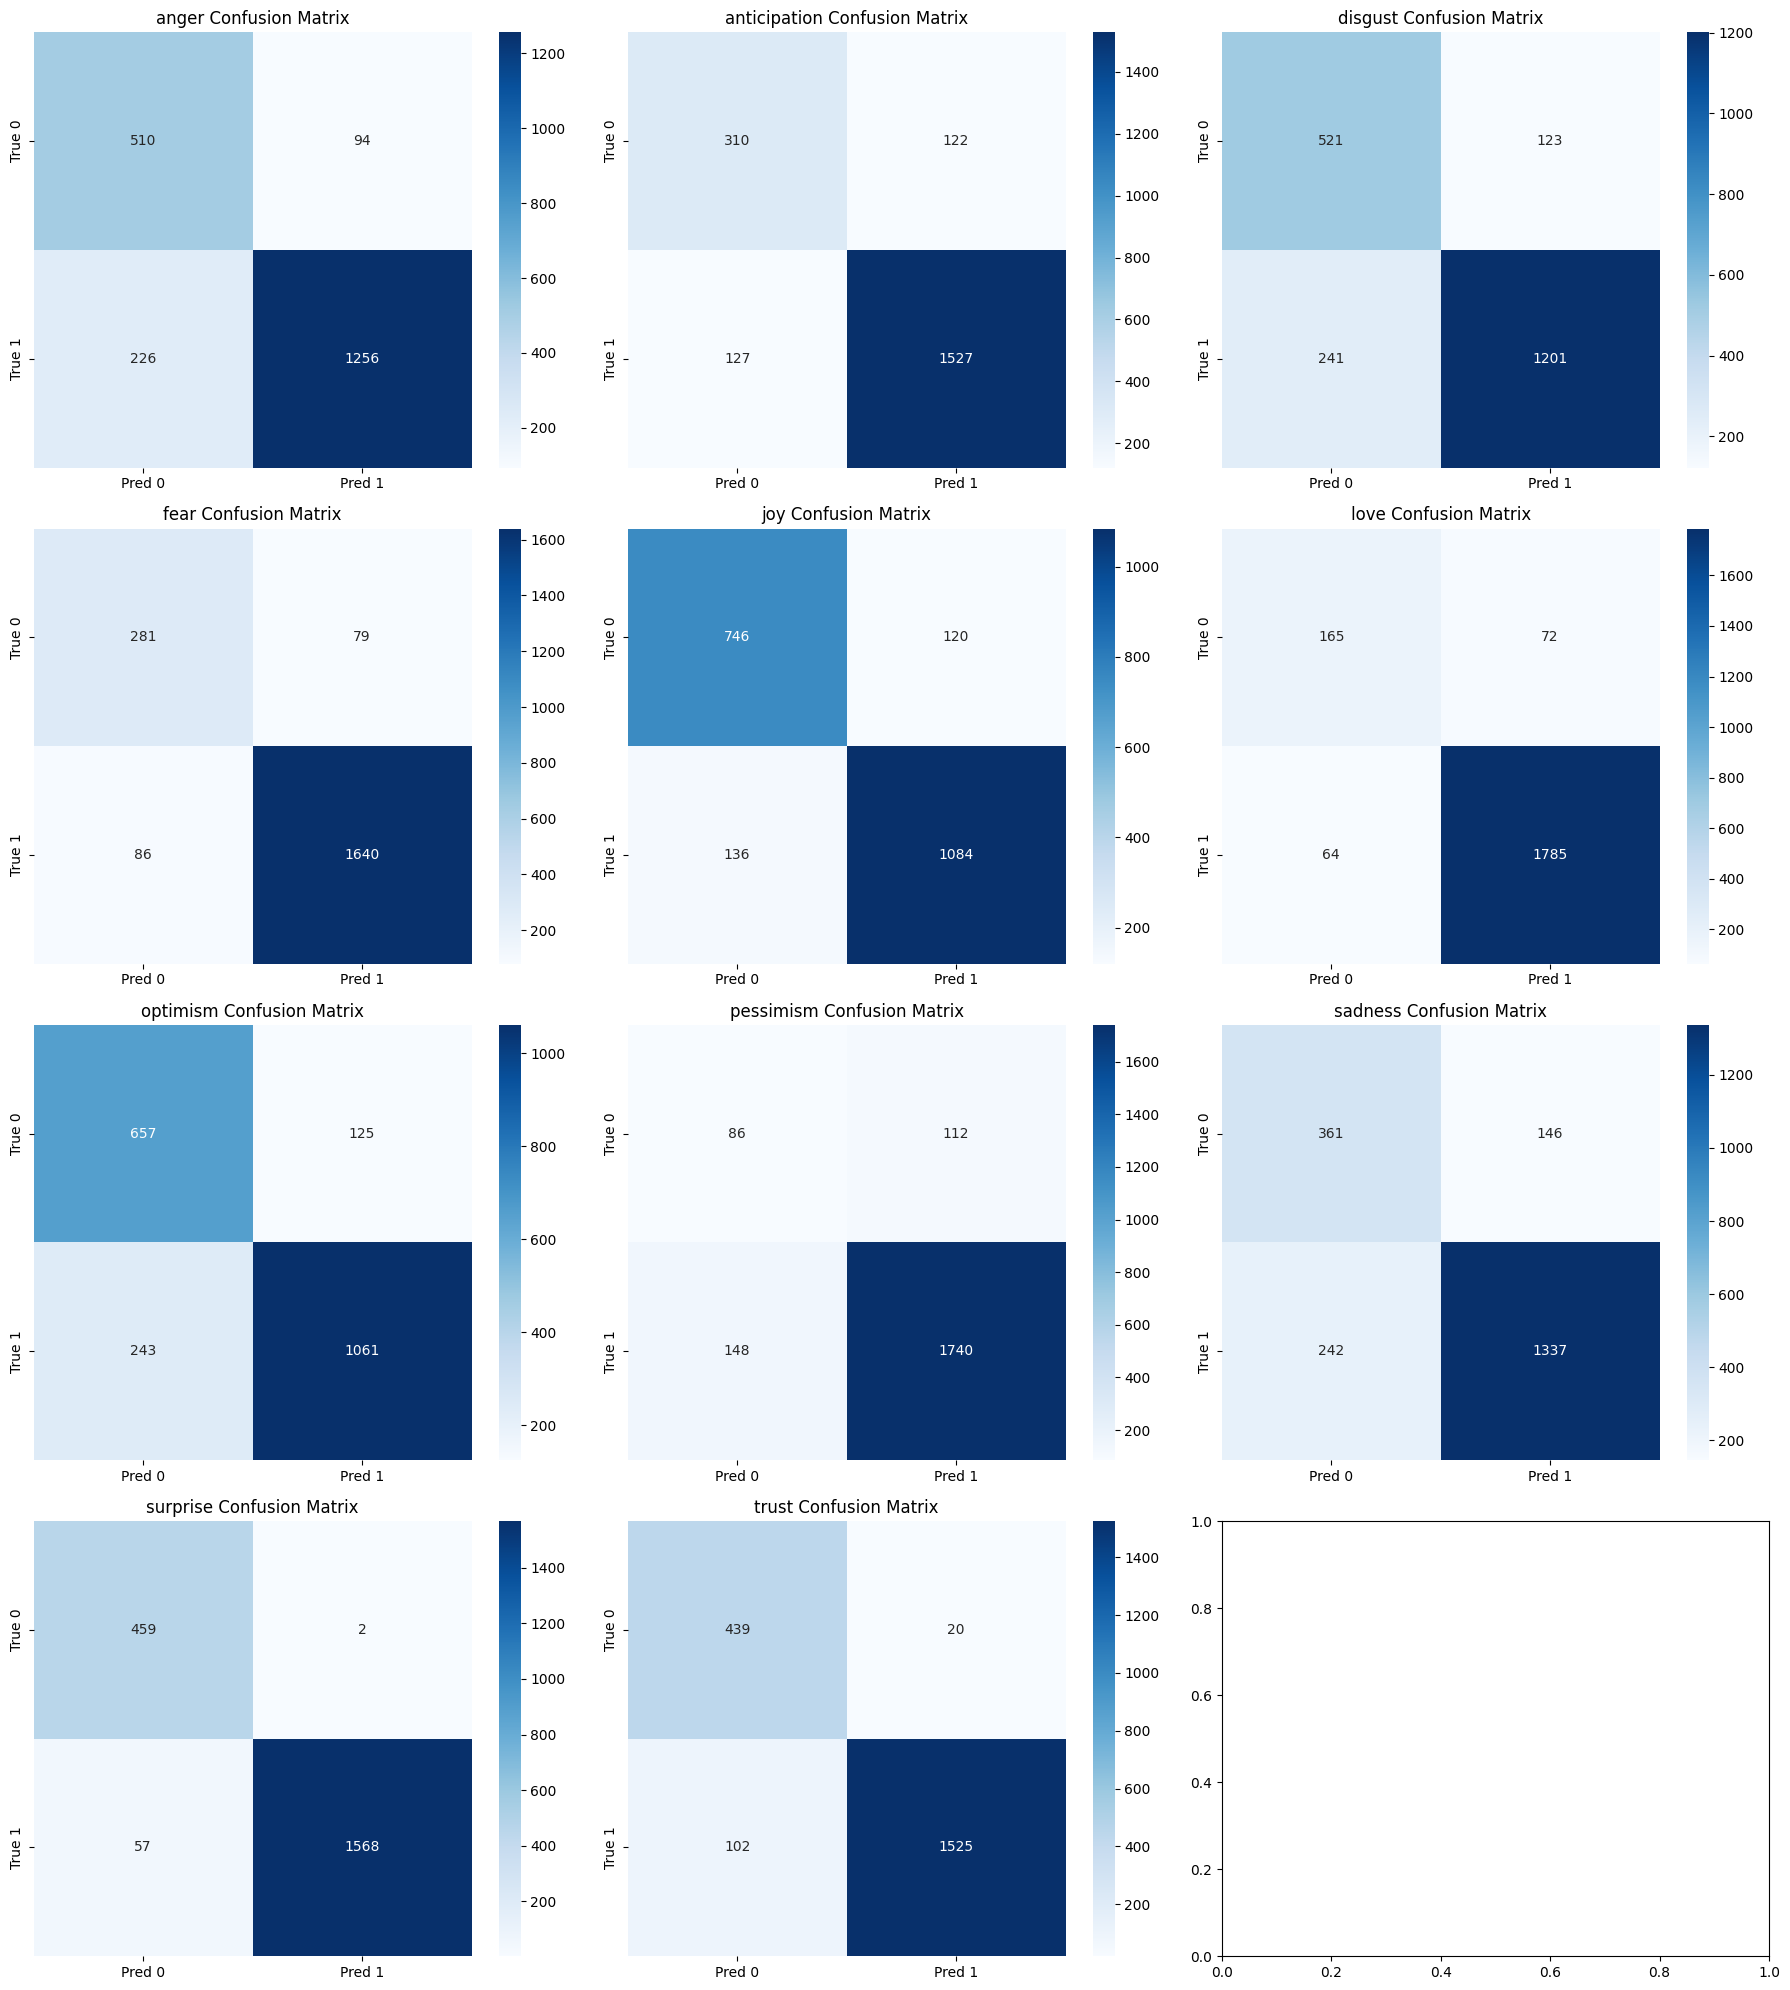

In [ ]:
#Grid of confusion matrices
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.ravel()

for i, emotion in enumerate(emotions):
    cm = multilabel_confusion_matrix(Y_test_values[:,i], pred_labels[:,i])[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    axes[i].set_title(f'{emotion} Confusion Matrix')

plt.tight_layout()
plt.show()

**Sample Predictions**

In [ ]:
# Sample Predictions
sample_idx = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_idx:
    print(f"Tweet: {X_test.iloc[idx]}")
    print("True Labels:", [emotions[i] for i, val in enumerate(Y_test_values[idx]) if val == 1])
    print("Predicted Labels:", [emotions[i] for i, val in enumerate(pred_labels[idx]) if val == 1])
    print("---")

Tweet: tiangong china s first space laboratory will come to a fiery end in late the average decommissioned satellite either burns
True Labels: []
Predicted Labels: ['anger', 'disgust', 'optimism']
---
Tweet: whatt a trailerrrr ranbirkapoor aishwaryaraibachchan i am completely blown longingformore
True Labels: ['anticipation', 'joy', 'optimism']
Predicted Labels: ['anticipation', 'joy', 'optimism', 'surprise', 'trust']
---
Tweet: i found the first few episodes of bojack incredibly funny then it got less funny but i stayed for the drama
True Labels: ['anticipation', 'joy', 'trust']
Predicted Labels: ['anticipation', 'joy', 'optimism', 'trust']
---
Tweet: i agree btw have u seen ep granger o that was the episode when i knew anna was coming back the conversation at start
True Labels: ['anticipation', 'optimism', 'surprise']
Predicted Labels: ['anticipation', 'optimism', 'surprise']
---
Tweet: muslims have been in usa for ages to think that muslims commit terrorism due to islam you gotta be